Товарищи, мы все уже великие специалисты в нейронных сетях, поэтому пришло время показать это миру. Мы будем решать конкурс от роснефти по сегментации изображений. У нас будут изображения с трехмерного куба, где надо найти различные области на этих снимках. А дальше уже смотрите сами :)

Более подробно о данном конкурсе можно посмотреть вот тута :
[ссылочка](https://boosters.pro/championship/seismic_challenge/overview)


В рамках данной домашки попробуем вспомнить все, что нам мы делали.

Дальше будет о подгрузке данных и небольшие направления деятельности, но в основном ваше фантазия решает этот конкурс :)


In [9]:
import tensorflow as tf
# import tensorflow_hub as hub


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




import pandas as pd
import numpy as np
import cv2 # подгрузка и работа с данными
import os
import tqdm # счетчик и красивый прогресс бар

IMAGE_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/train/images/'
MASK_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/train/train.csv'
TEST_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/test/images/'
SAMPLE_PATH = '/storage/Study/DBO/dl/rosneft_challenge/rosneft_challenge/make_rofneft_predict/data/sample_submission.csv'

def rle2mask(mask_rle, shape):
    # эта функция взята с конкурса и я её оставил как есть
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

class TrainDataset():
    # немного переписанный загрузчик данных опять же с конкурса
    def __init__(self, image_dir, train):
        self.image_dir = image_dir
        self.train = train
        self.image_uses = []

    def __getitem__(self, index):
        
        
        img_name = self.train.iloc[index]['ImageId']
        if img_name in self.image_uses:
            return 'hups'
        else:
            self.image_uses.append(img_name)
            path = os.path.join(self.image_dir, img_name)
            img = cv2.imread(path)
            img = cv2.resize(img,(384,384))

            ce_mask = [
                (i + 1) * rle2mask(rle, shape=(img.shape[0], img.shape[1])) \
                    for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
            ]
            ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)


            result = {
                'image':img, 
                'mask': ce_mask,
                'pick_name':img_name
            }
            return result
    
    def __len__(self, ):
        return len(self.train)
    
train = pd.read_csv(MASK_PATH)
train_dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=train)


Кстати, посмотрев на данные, какие особенности данных мы видим?

In [10]:
x_images = []
y_images = []
for i in train_dataset:
    if type(i)==str:
        pass
    else:
        x_images.append(i['image'])
        y_images.append(i['mask']) 
            

In [13]:
# x_images

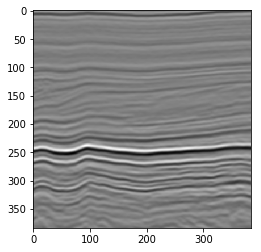

In [14]:
plt.imshow(x_images[0])

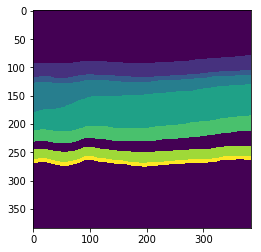

In [16]:
plt.imshow(y_images[0])

In [ ]:
# Оставить один канал, т.к. ч/б
# проверить что in и y картинки не ращличаются
# 
# 
# 
# 
# 


Такс, что мы хотим делать с данными дальше ? Можем ли мы что-то предположить заранее?

In [ ]:
#### Ваш код игры с данными

В самой задачке на бустере используется метрика dice по границе и всей области.
Мы упростим задачу, просто берем dice по области.

Собственно нам надо реализовать следующую формулу

\begin{equation}
dice = \sum_{k=0}^7(\cfrac{2*|prediction \cap truch|}{|prediction| + |truch|})
\end{equation}

Ну и чтобы в случае чего не делить на ноль, надо добавить небольшой эпсилон к верхней и нижней части.

In [13]:
def dice_metric(y_true,y_pred):
    # по доке мы принимаем на вход 2 тензора
    # отдавать же должны скаляр
    pass

Придумываем бейзлайн для всего нашего кусочка - должны же мы его превзойти!

In [28]:
class_list = [1,2,3,4,5,6,7]

In [33]:
# Код бейзлайна
# Сделаем среднюю карту по y и назовем это бейзлайном
print(len(y_images))
print(y_images[0].shape)

obj_class = {}
dict_start = {}
dict_end = {}

first_col = y_images[0][:,0]

for obj_class in class_list:
    for i in range(1,len(first_col)):
        if first_col[i]==obj_class and first_col[i-1] != obj_class:
            dict_start[obj_class] = i
        elif first_col[i-1]==obj_class and first_col[i] == obj_class:
            dict_end[obj_class] = i
            break
            

print(dict_start)            
print(dict_end)



896
(384, 384)
{1: 94, 2: 119, 3: 128, 4: 180, 5: 213, 6: 246, 7: 264}
{1: 95, 2: 120, 3: 129, 4: 181, 5: 214, 6: 247, 7: 265}


In [37]:
dict_start = {}
dict_end = {}

for i in class_list:
    dict_start[i] = []
    dict_end[i] = []

    
for y_trr in y_images:
    first_col = y_trr[:,0]
    for obj_class in class_list:
        for i in range(1,len(first_col)):
            if first_col[i]==obj_class and first_col[i-1] != obj_class:
                dict_start[obj_class].append(i)
            elif first_col[i-1]==obj_class and first_col[i] == obj_class:
                dict_end[obj_class].append(i)
                break
            

print(dict_start)            
print(dict_end)

    

{1: [94, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 95, 92, 94, 94, 95, 96, 97, 98, 98, 99, 100, 100, 100, 98, 97, 97, 96, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 95, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 9

In [39]:
dict_total = {}
for obj_class in class_list:
    dict_total[obj_class] = [np.median(dict_start[obj_class]),
                            np.median(dict_end[obj_class])]
dict_total

{1: [93.0, 94.0],
 2: [117.0, 118.0],
 3: [126.0, 127.0],
 4: [177.0, 178.0],
 5: [206.0, 207.0],
 6: [248.0, 249.0],
 7: [266.0, 267.0]}

Ну что же, теперь пришло время к моделям!
Начнем с простой модельки - fully-convolution-net.

И да - архитектура на ваш вкус и цвет :)

Но прежде чем начинать, какие callback нам точно потребуются? (вне зависимости от архитектуры)

In [ ]:
# Собираем fully-convolution-net


Собираем u-net. Смотрим как оно :)

In [ ]:
# Собираем fully-convolution-net

Ну чтож, время вашего творчества - меняем архитектуры, смотрим и вспоминаем, что же ещё мы не учли и что может нам помочь. Да и вообще -какие подходы ещё не использованы !

In [ ]:
### играемся на все деньги

И доп задачка для всех - а что если обучить часть (или весь) unet как автоэнкодер.....


In [ ]:
##############################